# Feature Engineering and Modeling

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LassoCV, Lasso
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
df = pd.read_csv("Datasets/clean_data_after_eda.csv")
df["date_activ"] = pd.to_datetime(df["date_activ"], format = '%Y-%m-%d')
df["date_end"] = pd.to_datetime(df["date_end"], format = '%Y-%m-%d')
df["date_modif_prod"] = pd.to_datetime(df["date_modif_prod"], format = '%Y-%m-%d')
df["date_renewal"] = pd.to_datetime(df["date_renewal"], format = '%Y-%m-%d')
df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,var_6m_price_off_peak_var,var_6m_price_peak_var,var_6m_price_mid_peak_var,var_6m_price_off_peak_fix,var_6m_price_peak_fix,var_6m_price_mid_peak_fix,var_6m_price_off_peak,var_6m_price_peak,var_6m_price_mid_peak,churn
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,0.000131,4.100838e-05,9.084737e-04,2.086294,99.530517,44.235794,2.086425,9.953056e+01,4.423670e+01,1
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.000003,1.217891e-03,0.000000e+00,0.009482,0.000000,0.000000,0.009485,1.217891e-03,0.000000e+00,0
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.000004,9.450150e-08,0.000000e+00,0.000000,0.000000,0.000000,0.000004,9.450150e-08,0.000000e+00,0
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,0.000003,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000003,0.000000e+00,0.000000e+00,0
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,...,0.000011,2.896760e-06,4.860000e-10,0.000000,0.000000,0.000000,0.000011,2.896760e-06,4.860000e-10,0


## Creating Columns in Price Data

The first thing I needed to do was create new columns based on the prices and their period. I wanted to continue making more difference features while also making some for average and sum.

In [6]:
price_df = pd.read_csv("Datasets/price_data.csv")
price_df["price_date"] = pd.to_datetime(price_df["price_date"], format='%Y-%m-%d')
price_df.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


In [7]:
# Group off-peak prices by companies and month
monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean'}).reset_index()

# Get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference
diff_1 = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}), jan_prices.drop(columns='price_date'), on='id')
diff_1['offpeak_diff_dec_january_energy'] = diff_1['dec_1'] - diff_1['price_off_peak_var']
diff_1['offpeak_diff_dec_january_power'] = diff_1['dec_2'] - diff_1['price_off_peak_fix']
diff_1 = diff_1[['id', 'offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power']]
diff_1.head()

,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779
2,0010bcc39e42b3c2131ed2ce55246e3c,0.050443,1.500000
3,0010ee3855fdea87602a5b7aba8e42de,-0.010018,0.162916
4,00114d74e963e47177db89bc70108537,-0.003994,-0.000001


In [8]:
# Group peak prices by companies and month
monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_peak_var': 'mean', 'price_peak_fix': 'mean'}).reset_index()

jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

diff_2 = pd.merge(dec_prices.rename(columns={'price_peak_var': 'dec_1', 'price_peak_fix': 'dec_2'}), jan_prices.drop(columns='price_date'), on='id')
diff_2['peak_diff_dec_january_energy'] = diff_2['dec_1'] - diff_2['price_peak_var']
diff_2['peak_diff_dec_january_power'] = diff_2['dec_2'] - diff_2['price_peak_fix']
diff_2 = diff_2[['id', 'peak_diff_dec_january_energy','peak_diff_dec_january_power']]
diff_2.head()

,id,peak_diff_dec_january_energy,peak_diff_dec_january_power
0,0002203ffbb812588b632b9e628cc38d,-0.002302,0.097749
1,0004351ebdd665e6ee664792efc4fd13,0.000000,0.000000
2,0010bcc39e42b3c2131ed2ce55246e3c,0.000000,0.000000
3,0010ee3855fdea87602a5b7aba8e42de,-0.005120,0.097749
4,00114d74e963e47177db89bc70108537,0.000000,0.000000


In [9]:
# Group mid-peak prices by companies and month
monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_mid_peak_var': 'mean', 'price_mid_peak_fix': 'mean'}).reset_index()

jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

diff_3 = pd.merge(dec_prices.rename(columns={'price_mid_peak_var': 'dec_1', 'price_mid_peak_fix': 'dec_2'}), jan_prices.drop(columns='price_date'), on='id')
diff_3['midpeak_diff_dec_january_energy'] = diff_3['dec_1'] - diff_3['price_mid_peak_var']
diff_3['midpeak_diff_dec_january_power'] = diff_3['dec_2'] - diff_3['price_mid_peak_fix']
diff_3 = diff_3[['id', 'midpeak_diff_dec_january_energy','midpeak_diff_dec_january_power']]
diff_3.head()

,id,midpeak_diff_dec_january_energy,midpeak_diff_dec_january_power
0,0002203ffbb812588b632b9e628cc38d,0.003487,0.065166
1,0004351ebdd665e6ee664792efc4fd13,0.000000,0.000000
2,0010bcc39e42b3c2131ed2ce55246e3c,0.000000,0.000000
3,0010ee3855fdea87602a5b7aba8e42de,0.000763,0.065166
4,00114d74e963e47177db89bc70108537,0.000000,0.000000


In the above three cells blocks. I got the difference of Decemeber and January prices of each company between the columns price_off_peak_var with price_off_peak_fix, price_peak_var with price_peak_fix, and price_mid_peak_var with price_mid_peak_fix.

In [11]:
pre_diff = pd.merge(diff_1, diff_2, on = "id")
diff_df = pd.merge(pre_diff, diff_3, on = "id")
diff_df.head()

,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,peak_diff_dec_january_energy,peak_diff_dec_january_power,midpeak_diff_dec_january_energy,midpeak_diff_dec_january_power
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916,-0.002302,0.097749,0.003487,0.065166
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779,0.000000,0.000000,0.000000,0.000000
2,0010bcc39e42b3c2131ed2ce55246e3c,0.050443,1.500000,0.000000,0.000000,0.000000,0.000000
3,0010ee3855fdea87602a5b7aba8e42de,-0.010018,0.162916,-0.005120,0.097749,0.000763,0.065166
4,00114d74e963e47177db89bc70108537,-0.003994,-0.000001,0.000000,0.000000,0.000000,0.000000


I then merge each of the difference datasets based on the company.

In [13]:
avg_df = price_df.groupby(["id"]).mean().drop(columns= "price_date")
avg_df = avg_df.rename(columns = {"price_off_peak_var": "avg_price_off_peak_var", "price_peak_var": "avg_price_peak_var", "price_mid_peak_var": "avg_price_mid_peak_var", "price_off_peak_fix": "avg_price_off_peak_fix", "price_peak_fix": "avg_price_peak_fix", "price_mid_peak_fix": "avg_price_mid_peak_fix"})
avg_df.head()

,avg_price_off_peak_var,avg_price_peak_var,avg_price_mid_peak_var,avg_price_off_peak_fix,avg_price_peak_fix,avg_price_mid_peak_fix
id,,,,,,
0002203ffbb812588b632b9e628cc38d,0.124338,0.103794,0.073160,40.701732,24.421038,16.280694
0004351ebdd665e6ee664792efc4fd13,0.146426,0.000000,0.000000,44.385450,0.000000,0.000000
0010bcc39e42b3c2131ed2ce55246e3c,0.181558,0.000000,0.000000,45.319710,0.000000,0.000000
0010ee3855fdea87602a5b7aba8e42de,0.118757,0.098292,0.069032,40.647427,24.388455,16.258971
00114d74e963e47177db89bc70108537,0.147926,0.000000,0.000000,44.266930,0.000000,0.000000


Here I got the average of the prices of each company based on the same columns.

In [15]:
sum_df = price_df.groupby(["id"]).mean().drop(columns= "price_date")
sum_df = sum_df.rename(columns = {"price_off_peak_var": "sum_price_off_peak_var", "price_peak_var": "sum_price_peak_var", "price_mid_peak_var": "sum_price_mid_peak_var", "price_off_peak_fix": "sum_price_off_peak_fix", "price_peak_fix": "sum_price_peak_fix", "price_mid_peak_fix": "sum_price_mid_peak_fix"})
sum_df.head()

,sum_price_off_peak_var,sum_price_peak_var,sum_price_mid_peak_var,sum_price_off_peak_fix,sum_price_peak_fix,sum_price_mid_peak_fix
id,,,,,,
0002203ffbb812588b632b9e628cc38d,0.124338,0.103794,0.073160,40.701732,24.421038,16.280694
0004351ebdd665e6ee664792efc4fd13,0.146426,0.000000,0.000000,44.385450,0.000000,0.000000
0010bcc39e42b3c2131ed2ce55246e3c,0.181558,0.000000,0.000000,45.319710,0.000000,0.000000
0010ee3855fdea87602a5b7aba8e42de,0.118757,0.098292,0.069032,40.647427,24.388455,16.258971
00114d74e963e47177db89bc70108537,0.147926,0.000000,0.000000,44.266930,0.000000,0.000000


I got the sum of the prices from the companies from the same columns.

In [17]:
sum_avg_df = pd.merge(sum_df, avg_df, on = "id")
diff_sum_avg_df= pd.merge(sum_avg_df, diff_df, on = "id")
diff_sum_avg_df.head()

,id,sum_price_off_peak_var,sum_price_peak_var,sum_price_mid_peak_var,sum_price_off_peak_fix,sum_price_peak_fix,sum_price_mid_peak_fix,avg_price_off_peak_var,avg_price_peak_var,avg_price_mid_peak_var,avg_price_off_peak_fix,avg_price_peak_fix,avg_price_mid_peak_fix,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,peak_diff_dec_january_energy,peak_diff_dec_january_power,midpeak_diff_dec_january_energy,midpeak_diff_dec_january_power
0,0002203ffbb812588b632b9e628cc38d,0.124338,0.103794,0.073160,40.701732,24.421038,16.280694,0.124338,0.103794,0.073160,40.701732,24.421038,16.280694,-0.006192,0.162916,-0.002302,0.097749,0.003487,0.065166
1,0004351ebdd665e6ee664792efc4fd13,0.146426,0.000000,0.000000,44.385450,0.000000,0.000000,0.146426,0.000000,0.000000,44.385450,0.000000,0.000000,-0.004104,0.177779,0.000000,0.000000,0.000000,0.000000
2,0010bcc39e42b3c2131ed2ce55246e3c,0.181558,0.000000,0.000000,45.319710,0.000000,0.000000,0.181558,0.000000,0.000000,45.319710,0.000000,0.000000,0.050443,1.500000,0.000000,0.000000,0.000000,0.000000
3,0010ee3855fdea87602a5b7aba8e42de,0.118757,0.098292,0.069032,40.647427,24.388455,16.258971,0.118757,0.098292,0.069032,40.647427,24.388455,16.258971,-0.010018,0.162916,-0.005120,0.097749,0.000763,0.065166
4,00114d74e963e47177db89bc70108537,0.147926,0.000000,0.000000,44.266930,0.000000,0.000000,0.147926,0.000000,0.000000,44.266930,0.000000,0.000000,-0.003994,-0.000001,0.000000,0.000000,0.000000,0.000000


These two additonal datasets were then merged with the difference dataset based on the company.

## Preparing Data for Feature Selection

In [20]:
pref_df = df.copy()
pref_df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,var_6m_price_off_peak_var,var_6m_price_peak_var,var_6m_price_mid_peak_var,var_6m_price_off_peak_fix,var_6m_price_peak_fix,var_6m_price_mid_peak_fix,var_6m_price_off_peak,var_6m_price_peak,var_6m_price_mid_peak,churn
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,0.000131,4.100838e-05,9.084737e-04,2.086294,99.530517,44.235794,2.086425,9.953056e+01,4.423670e+01,1
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.000003,1.217891e-03,0.000000e+00,0.009482,0.000000,0.000000,0.009485,1.217891e-03,0.000000e+00,0
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.000004,9.450150e-08,0.000000e+00,0.000000,0.000000,0.000000,0.000004,9.450150e-08,0.000000e+00,0
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,0.000003,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000003,0.000000e+00,0.000000e+00,0
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,...,0.000011,2.896760e-06,4.860000e-10,0.000000,0.000000,0.000000,0.000011,2.896760e-06,4.860000e-10,0


In [21]:
comparing = pref_df.apply(lambda x: x.margin_gross_pow_ele == x.margin_net_pow_ele, axis=1)
len(comparing[comparing == True])

14604

In the above cell, I was comparing two columns to see if I could merge them together. I found that there most was only 2 out pf 14606 that were different. 

In [23]:
pref_df = pref_df.drop(columns=["margin_gross_pow_ele"])
pref_df = pref_df.rename(columns = {"margin_net_pow_ele": "margin_gross_net_pow_ele"})

I changed dropped margin_gross_pow_ele and changed it into margin_gross_net_pow_ele as I found they were pratically the same.

In [25]:
column_names = pref_df.loc[:, pref_df.dtypes == object].columns
le = LabelEncoder()
for i in column_names[1:]:
    temp = le.fit_transform(pref_df[i])
    pref_df.drop(i, axis = 1, inplace = True )
    pref_df[i] = temp

I used LabelEncoder on the string columns so that they could have numerical values which is associated to the orginal value. This will make it easier to compare the columns to see which I need to drop or change while also preparing it for machine learning.

In [27]:
pref_df.iloc[:, -3:].head()

,channel_sales,has_gas,origin_up
0,4,1,4
1,0,0,2
2,4,0,2
3,5,0,2
4,0,0,2


In [28]:
pref_df["year_activ"] = pref_df["date_activ"].dt.year
pref_df["month_activ"] = pref_df["date_activ"].dt.month
pref_df["day_activ"] = pref_df["date_activ"].dt.day

In [29]:
pref_df["year_end"] = pref_df["date_end"].dt.year
pref_df["month_end"] = pref_df["date_end"].dt.month
pref_df["day_end"] = pref_df["date_end"].dt.day

In [30]:
pref_df["year_modif_prod"] = pref_df["date_modif_prod"].dt.year
pref_df["month_modif_prod"] = pref_df["date_modif_prod"].dt.month
pref_df["day_modif_prod"] = pref_df["date_modif_prod"].dt.day  

In [31]:
pref_df["year_renewal"] = pref_df["date_renewal"].dt.year
pref_df["month_renewal"] = pref_df["date_renewal"].dt.month
pref_df["day_renewal"] = pref_df["date_renewal"].dt.day

In the above four cells, I obtained the year, month, and day from each date column and seperated them into their own column. This could possibly help with determining the churn.

In [33]:
pref_df = pref_df.drop(columns=["date_activ", "date_end", "date_modif_prod", "date_renewal"])

Since I had the dates seperated into year, month, and day, there was no need to keep the orginal date.

In [35]:
pref_df.iloc[:, -12:].head()

,year_activ,month_activ,day_activ,year_end,month_end,day_end,year_modif_prod,month_modif_prod,day_modif_prod,year_renewal,month_renewal,day_renewal
0,2013,6,15,2016,6,15,2015,11,1,2015,6,23
1,2009,8,21,2016,8,30,2009,8,21,2015,8,31
2,2010,4,16,2016,4,16,2010,4,16,2015,4,17
3,2010,3,30,2016,3,30,2010,3,30,2015,3,31
4,2010,1,13,2016,3,7,2010,1,13,2015,3,9


In [36]:
pref_df = pd.merge(pref_df, diff_sum_avg_df, on = "id")

The diff_sum_avg_df is merged with the clean dataframe based on the id of the clients. This will add more features that could help to determine the churn.

In [38]:
pref_df = pref_df.drop(columns = "id")
pref_df.head()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,...,avg_price_mid_peak_var,avg_price_off_peak_fix,avg_price_peak_fix,avg_price_mid_peak_fix,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,peak_diff_dec_january_energy,peak_diff_dec_january_power,midpeak_diff_dec_january_energy,midpeak_diff_dec_january_power
0,0,54946,0,0.00,0,0.0,1.78,0.114481,0.098142,40.606701,...,0.066530,40.942265,22.352010,14.901340,0.020057,3.700961,-0.017912,-24.339581,-0.071536,-16.226389
1,4660,0,0,189.95,0,0.0,16.27,0.145711,0.000000,44.311378,...,0.000000,44.311375,0.000000,0.000000,-0.003767,0.177779,0.000000,0.000000,0.000000,0.000000
2,544,0,0,47.96,0,0.0,38.72,0.165794,0.087899,44.311378,...,0.000000,44.385450,0.000000,0.000000,-0.004670,0.177779,0.000528,0.000000,0.000000,0.000000
3,1584,0,0,240.04,0,0.0,19.83,0.146694,0.000000,44.311378,...,0.000000,44.400265,0.000000,0.000000,-0.004547,0.177779,0.000000,0.000000,0.000000,0.000000
4,4425,0,526,445.75,526,0.0,131.73,0.116900,0.100015,40.606701,...,0.072865,40.688156,24.412893,16.275263,-0.006192,0.162916,-0.002302,0.097749,0.003487,0.065166


In [39]:
churn_pop = pref_df.pop("churn")
pref_df.insert(len(pref_df.columns), "churn", churn_pop)

Since there was no need for the id column anymore, I removed it from dataset. It would not assist with determining the churn and would do more harm to the model than good.

### VIF

Here I wanted to determine if there was multicollinearity in the dataset. Having different variable be highly correlated might cause issues in the model.

In [43]:
X = pref_df.drop(["churn"], axis = 1)
y = pref_df["churn"] 

In [44]:
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

print(vif_data[vif_data["VIF"] >= 5])

C:\Users\Taco\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                            feature           VIF
0                          cons_12m  1.852050e+01
2                   cons_last_month  1.859076e+01
3                 forecast_cons_12m  6.488039e+00
4                forecast_cons_year  2.398302e+01
6           forecast_meter_rent_12m  1.031626e+01
7    forecast_price_energy_off_peak  1.981369e+03
8        forecast_price_energy_peak  3.272492e+02
9       forecast_price_pow_off_peak  2.655274e+03
10                         imp_cons  2.315291e+01
11         margin_gross_net_pow_ele  5.880941e+00
12                      nb_prod_act  9.663127e+00
14                  num_years_antig  2.168374e+02
15                          pow_max  7.135377e+00
16      var_year_price_off_peak_var           inf
17          var_year_price_peak_var           inf
18      var_year_price_mid_peak_var           inf
19      var_year_price_off_peak_fix           inf
20          var_year_price_peak_fix           inf
21      var_year_price_mid_peak_fix           inf


So we can see here that there are a lot of columns that seem to have a 1-1 correlation and those that have very strong relations. However, we can not be certain which are correlated with each other so we will move on to the next step.

### Filter

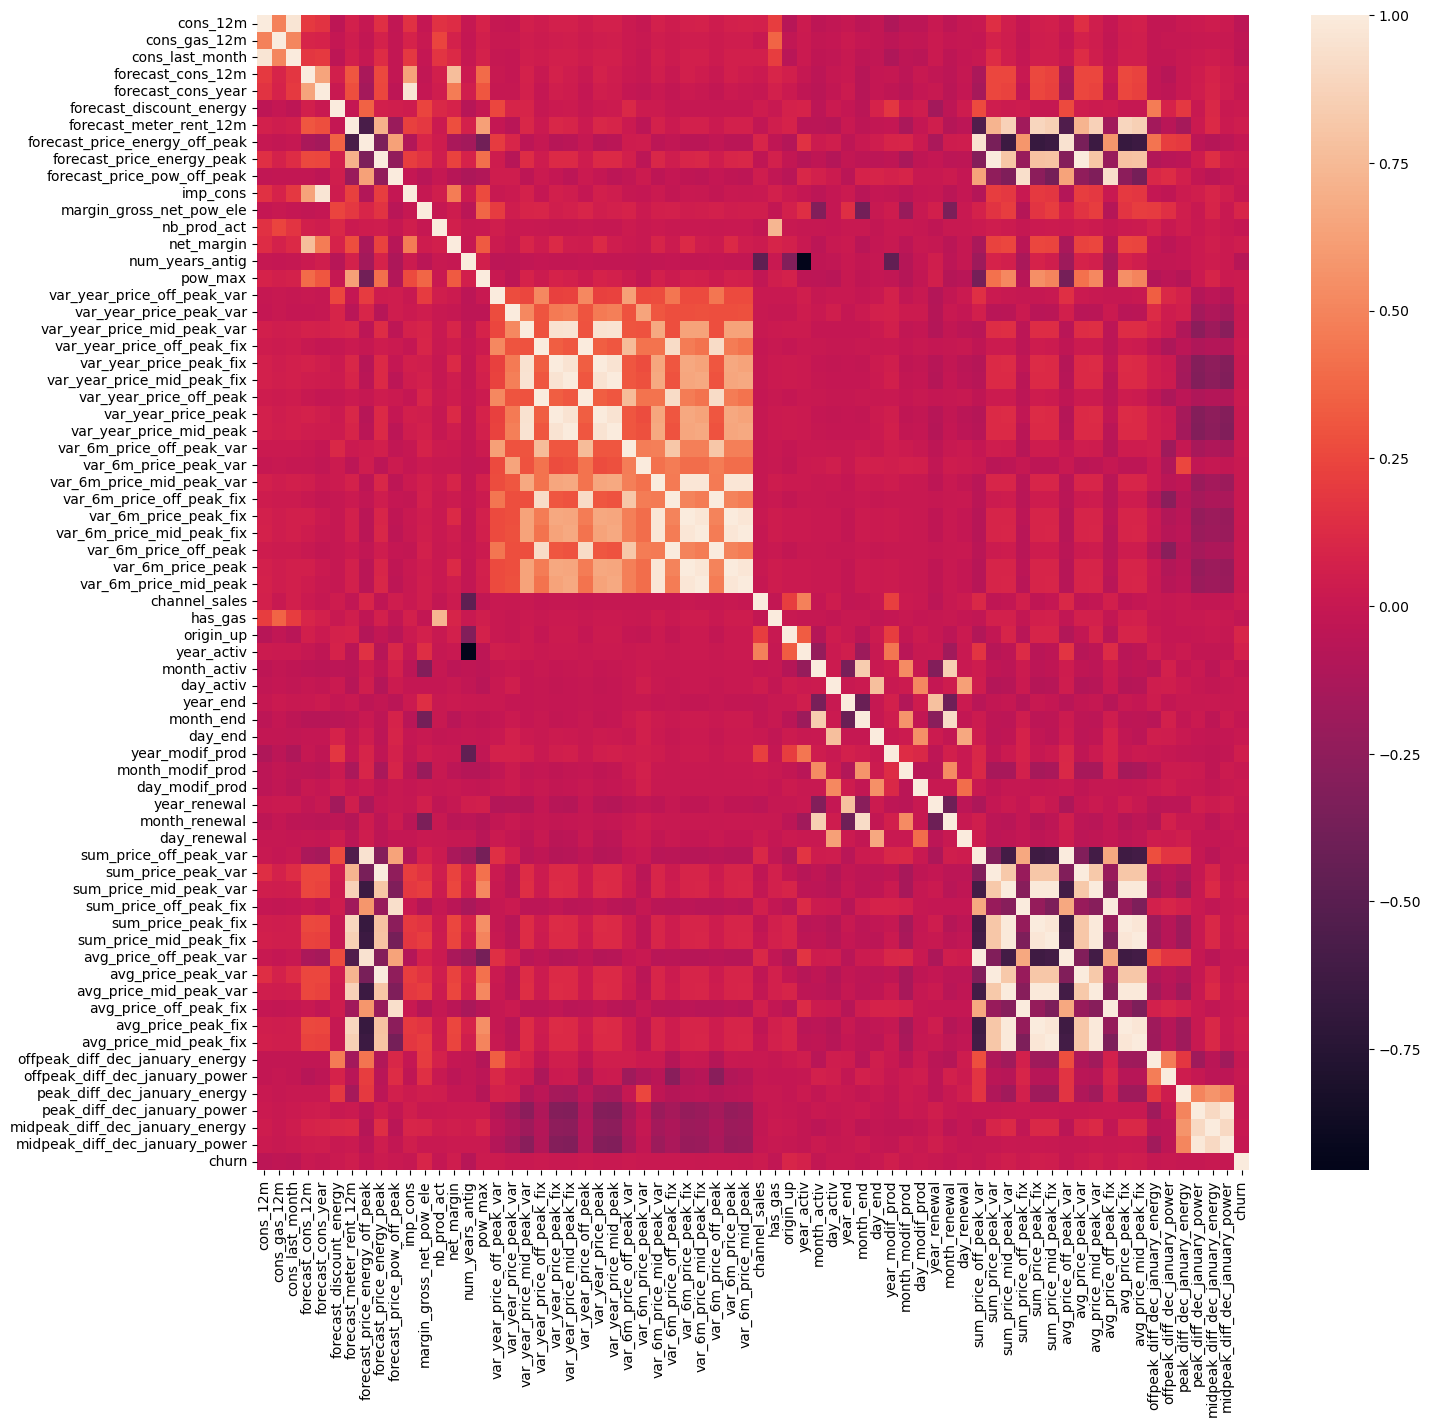

In [47]:
cor = pref_df.corr()
plt.rcParams['figure.figsize'] = (16.0, 15.0)
sns.heatmap(cor)
plt.show()

There is a lot of useful information to grab from this heatmap. I will only go through a few important points. The first is that we can see that several columns starting with var appear to have a high postive correlation with some nearly or reaching 1.0. So there are several columns from this group that will nead to be removed. The next we can see that the columns starting with sum or avg appear to have either a high postive or negative correlation. With the calulated VIF from earlier, we can easily see that we will certainly have to remove either some or all the columns mentioned so far. As we continue to look at it more, we can see that the heatmap helps to support the VIF data we made.

In [49]:
churn_cor = abs(cor["churn"])
print(churn_cor)

cons_12m                           0.045968
cons_gas_12m                       0.037957
cons_last_month                    0.045284
forecast_cons_12m                  0.012949
forecast_cons_year                 0.002558
                                     ...   
peak_diff_dec_january_energy       0.004041
peak_diff_dec_january_power        0.005183
midpeak_diff_dec_january_energy    0.000191
midpeak_diff_dec_january_power     0.002681
churn                              1.000000
Name: churn, Length: 68, dtype: float64


In [50]:
highly_relevant_features = churn_cor[churn_cor > 0.5]
highly_relevant_features

churn    1.0
Name: churn, dtype: float64

In [51]:
any_relevant_features = churn_cor[churn_cor > 0.1]
any_relevant_features

churn    1.0
Name: churn, dtype: float64

We can also see that there appear to be no features that have a high or really any correlation with churn.

#### Reducing Multicollinearity

In [59]:
#cor = round(cor, 2)
upper = cor.where(np.triu(np.ones(cor.shape), k=1).astype(np.bool_))

col_drop = [column for column in upper.columns if any(upper[column].abs() >= 0.95)]
print(col_drop)

['cons_last_month', 'imp_cons', 'var_year_price_mid_peak_fix', 'var_year_price_off_peak', 'var_year_price_peak', 'var_year_price_mid_peak', 'var_6m_price_peak_fix', 'var_6m_price_mid_peak_fix', 'var_6m_price_off_peak', 'var_6m_price_peak', 'var_6m_price_mid_peak', 'year_activ', 'sum_price_off_peak_var', 'sum_price_peak_var', 'sum_price_peak_fix', 'sum_price_mid_peak_fix', 'avg_price_off_peak_var', 'avg_price_peak_var', 'avg_price_mid_peak_var', 'avg_price_off_peak_fix', 'avg_price_peak_fix', 'avg_price_mid_peak_fix', 'midpeak_diff_dec_january_power']


The columns above are those that have a correlation of 95% or higher regardless if it is postive or negative. As I suspected, the columns here appear in the VIF data. This works out as we well be dropping these columns.

In [62]:
upper[col_drop][upper[col_drop].ge(0.95).any(axis = 1)]

,cons_last_month,imp_cons,var_year_price_mid_peak_fix,var_year_price_off_peak,var_year_price_peak,var_year_price_mid_peak,var_6m_price_peak_fix,var_6m_price_mid_peak_fix,var_6m_price_off_peak,var_6m_price_peak,...,sum_price_peak_var,sum_price_peak_fix,sum_price_mid_peak_fix,avg_price_off_peak_var,avg_price_peak_var,avg_price_mid_peak_var,avg_price_off_peak_fix,avg_price_peak_fix,avg_price_mid_peak_fix,midpeak_diff_dec_january_power
cons_12m,0.968212,0.159711,0.064262,0.030637,0.062237,0.064262,0.067322,0.069571,0.030496,0.067322,...,0.142933,0.051751,0.055081,0.000694,0.142933,0.050555,-0.013744,0.051751,0.055081,0.019365
forecast_cons_year,NaN,0.969395,0.037002,-0.013091,0.052200,0.037002,0.016133,0.006168,-0.017138,0.016133,...,0.250163,0.251802,0.224427,-0.152376,0.250163,0.233792,-0.025582,0.251802,0.224427,0.040062
forecast_price_energy_off_peak,NaN,-0.092535,-0.058733,-0.001997,-0.068999,-0.058733,-0.056840,-0.056026,-0.029616,-0.056839,...,-0.355831,-0.665798,-0.645149,0.951222,-0.355831,-0.643987,0.575805,-0.665798,-0.645149,-0.049704
forecast_price_energy_peak,NaN,0.212317,0.118191,0.036132,0.120274,0.118191,0.098052,0.099233,0.038774,0.098051,...,0.994046,0.791487,0.796767,-0.299122,0.994046,0.803913,-0.207921,0.791487,0.796767,0.040805
var_year_price_mid_peak_var,NaN,NaN,0.961481,0.296691,0.948579,0.961483,0.637463,0.638773,0.276627,0.637464,...,0.131231,0.130514,0.130826,-0.066374,0.131231,0.137567,-0.049333,0.130514,0.130826,-0.277338
var_year_price_off_peak_fix,NaN,NaN,0.310471,1.000000,0.340724,0.310471,0.460190,0.426243,0.919000,0.460194,...,0.023604,0.031605,0.027474,-0.033556,0.023604,0.029337,-0.048834,0.031605,0.027474,-0.094991
var_year_price_peak_fix,NaN,NaN,0.954353,0.340723,1.000000,0.954354,0.662291,0.637355,0.310611,0.662291,...,0.119196,0.127487,0.115496,-0.081171,0.119196,0.124232,-0.025335,0.127487,0.115496,-0.301130
var_year_price_mid_peak_fix,NaN,NaN,NaN,0.310472,0.954354,1.000000,0.650680,0.670265,0.290757,0.650680,...,0.117259,0.115157,0.120732,-0.071723,0.117259,0.121219,-0.059406,0.115157,0.120732,-0.316996
var_year_price_peak,NaN,NaN,NaN,NaN,NaN,0.954355,0.662291,0.637355,0.310613,0.662291,...,0.119194,0.127485,0.115494,-0.081169,0.119194,0.124230,-0.025334,0.127485,0.115494,-0.301131
var_6m_price_mid_peak_var,NaN,NaN,NaN,NaN,NaN,NaN,0.970093,0.976743,0.450766,0.970093,...,0.093051,0.092110,0.095755,-0.065331,0.093051,0.097225,-0.057302,0.092110,0.095755,-0.196071


Here are the postive correlations of the selected columns are shown with the column they are highly correlated with.

In [65]:
print([column for column in upper.columns if any(upper[column] <= -0.95)])

['year_activ']


In [67]:
print(upper["year_activ"][upper[col_drop].le(-0.95).any(axis = 1)])

num_years_antig   -0.954474
Name: year_activ, dtype: float64


I found there was only one highly negative correlation which was year_activ with num_years_antig.

In [70]:
vif_df = pref_df.drop(col_drop, axis = 1)

vif_df.head()

,cons_12m,cons_gas_12m,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,margin_gross_net_pow_ele,...,month_renewal,day_renewal,sum_price_mid_peak_var,sum_price_off_peak_fix,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,peak_diff_dec_january_energy,peak_diff_dec_january_power,midpeak_diff_dec_january_energy,churn
0,0,54946,0.00,0,0.0,1.78,0.114481,0.098142,40.606701,25.44,...,6,23,0.066530,40.942265,0.020057,3.700961,-0.017912,-24.339581,-0.071536,1
1,4660,0,189.95,0,0.0,16.27,0.145711,0.000000,44.311378,16.38,...,8,31,0.000000,44.311375,-0.003767,0.177779,0.000000,0.000000,0.000000,0
2,544,0,47.96,0,0.0,38.72,0.165794,0.087899,44.311378,28.60,...,4,17,0.000000,44.385450,-0.004670,0.177779,0.000528,0.000000,0.000000,0
3,1584,0,240.04,0,0.0,19.83,0.146694,0.000000,44.311378,30.22,...,3,31,0.000000,44.400265,-0.004547,0.177779,0.000000,0.000000,0.000000,0
4,4425,0,445.75,526,0.0,131.73,0.116900,0.100015,40.606701,44.91,...,3,9,0.072865,40.688156,-0.006192,0.162916,-0.002302,0.097749,0.003487,0


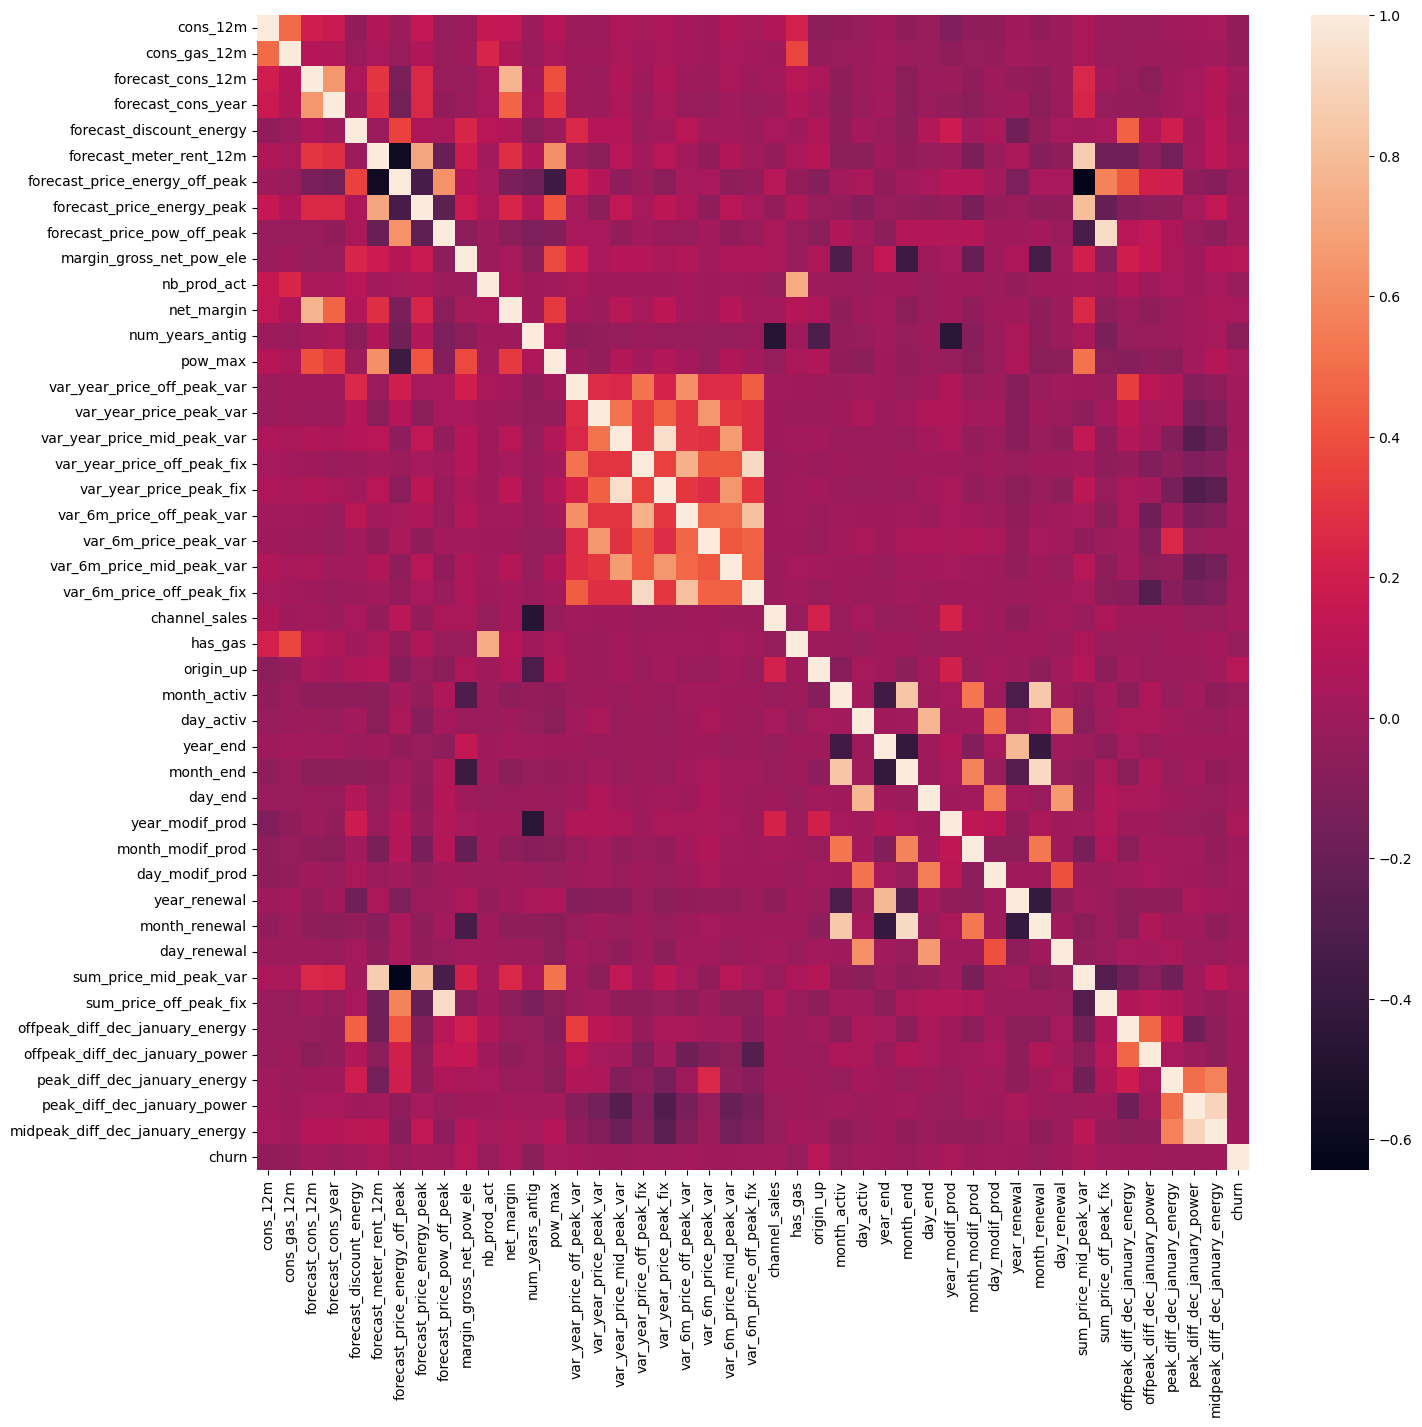

In [72]:
cor = vif_df.corr()
plt.rcParams["figure.figsize"] = (16.0, 15.0)
sns.heatmap(cor)
plt.show()

After the filtered clean, the change to the heatmap could be easily seen as it is not as bright partially due to removing columns and the range being higher now.

### Cleaning through VIF Data

Now we calculate the new VIF of each feature to see if anymore columns have to be dropped.

In [77]:
X = vif_df.drop(["churn"], axis = 1)
y = vif_df["churn"] 

In [79]:
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

print(vif_data[vif_data["VIF"] >= 5])

                            feature           VIF
2                 forecast_cons_12m  6.004676e+00
5           forecast_meter_rent_12m  1.005380e+01
6    forecast_price_energy_off_peak  3.049382e+02
7        forecast_price_energy_peak  1.110169e+01
8       forecast_price_pow_off_peak  9.996918e+02
9          margin_gross_net_pow_ele  5.576934e+00
10                      nb_prod_act  9.545454e+00
12                  num_years_antig  1.821329e+01
13                          pow_max  6.962177e+00
16      var_year_price_mid_peak_var  1.542803e+01
17      var_year_price_off_peak_fix  8.847910e+00
18          var_year_price_peak_fix  1.352223e+01
22        var_6m_price_off_peak_fix  1.164307e+01
25                        origin_up  1.655923e+01
26                      month_activ  1.786469e+01
27                        day_activ  9.776303e+00
28                         year_end  2.301455e+08
29                        month_end  6.310905e+01
30                          day_end  1.208389e+01


It would appear there are several columns that are affecting the VIF. To fix this, I decided it was best to remove the highest and go from there to see how that turned out.

In [81]:
clean_vif_df = vif_df.drop(["year_end", "year_modif_prod", "forecast_price_pow_off_peak", "forecast_price_energy_off_peak", "year_renewal", "month_end", "sum_price_off_peak_fix", "month_renewal", "var_year_price_mid_peak_var", "var_6m_price_off_peak_fix", "day_end", "origin_up", "sum_price_mid_peak_var"], axis = 1)
X = clean_vif_df.drop(["churn"], axis = 1)
y = clean_vif_df["churn"]

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

#  "year_end", "year_modif_prod", "forecast_price_pow_off_peak", "forecast_price_energy_off_peak", "year_renewal",
# year_end, year_modif_prod
# num_years_antig
print(vif_data[vif_data["VIF"] >= 10])

Empty DataFrame
Columns: [feature, VIF]
Index: []


After several reworks and changes to the dataset, I found that the columns I have chosen to drop resulted in the dataset having no feature equal or above 10 VIF.

In [85]:
clean_vif_df.head()

,cons_12m,cons_gas_12m,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_peak,margin_gross_net_pow_ele,nb_prod_act,net_margin,...,day_activ,month_modif_prod,day_modif_prod,day_renewal,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,peak_diff_dec_january_energy,peak_diff_dec_january_power,midpeak_diff_dec_january_energy,churn
0,0,54946,0.00,0,0.0,1.78,0.098142,25.44,2,678.99,...,15,11,1,23,0.020057,3.700961,-0.017912,-24.339581,-0.071536,1
1,4660,0,189.95,0,0.0,16.27,0.000000,16.38,1,18.89,...,21,8,21,31,-0.003767,0.177779,0.000000,0.000000,0.000000,0
2,544,0,47.96,0,0.0,38.72,0.087899,28.60,1,6.60,...,16,4,16,17,-0.004670,0.177779,0.000528,0.000000,0.000000,0
3,1584,0,240.04,0,0.0,19.83,0.000000,30.22,1,25.46,...,30,3,30,31,-0.004547,0.177779,0.000000,0.000000,0.000000,0
4,4425,0,445.75,526,0.0,131.73,0.100015,44.91,1,47.98,...,13,1,13,9,-0.006192,0.162916,-0.002302,0.097749,0.003487,0


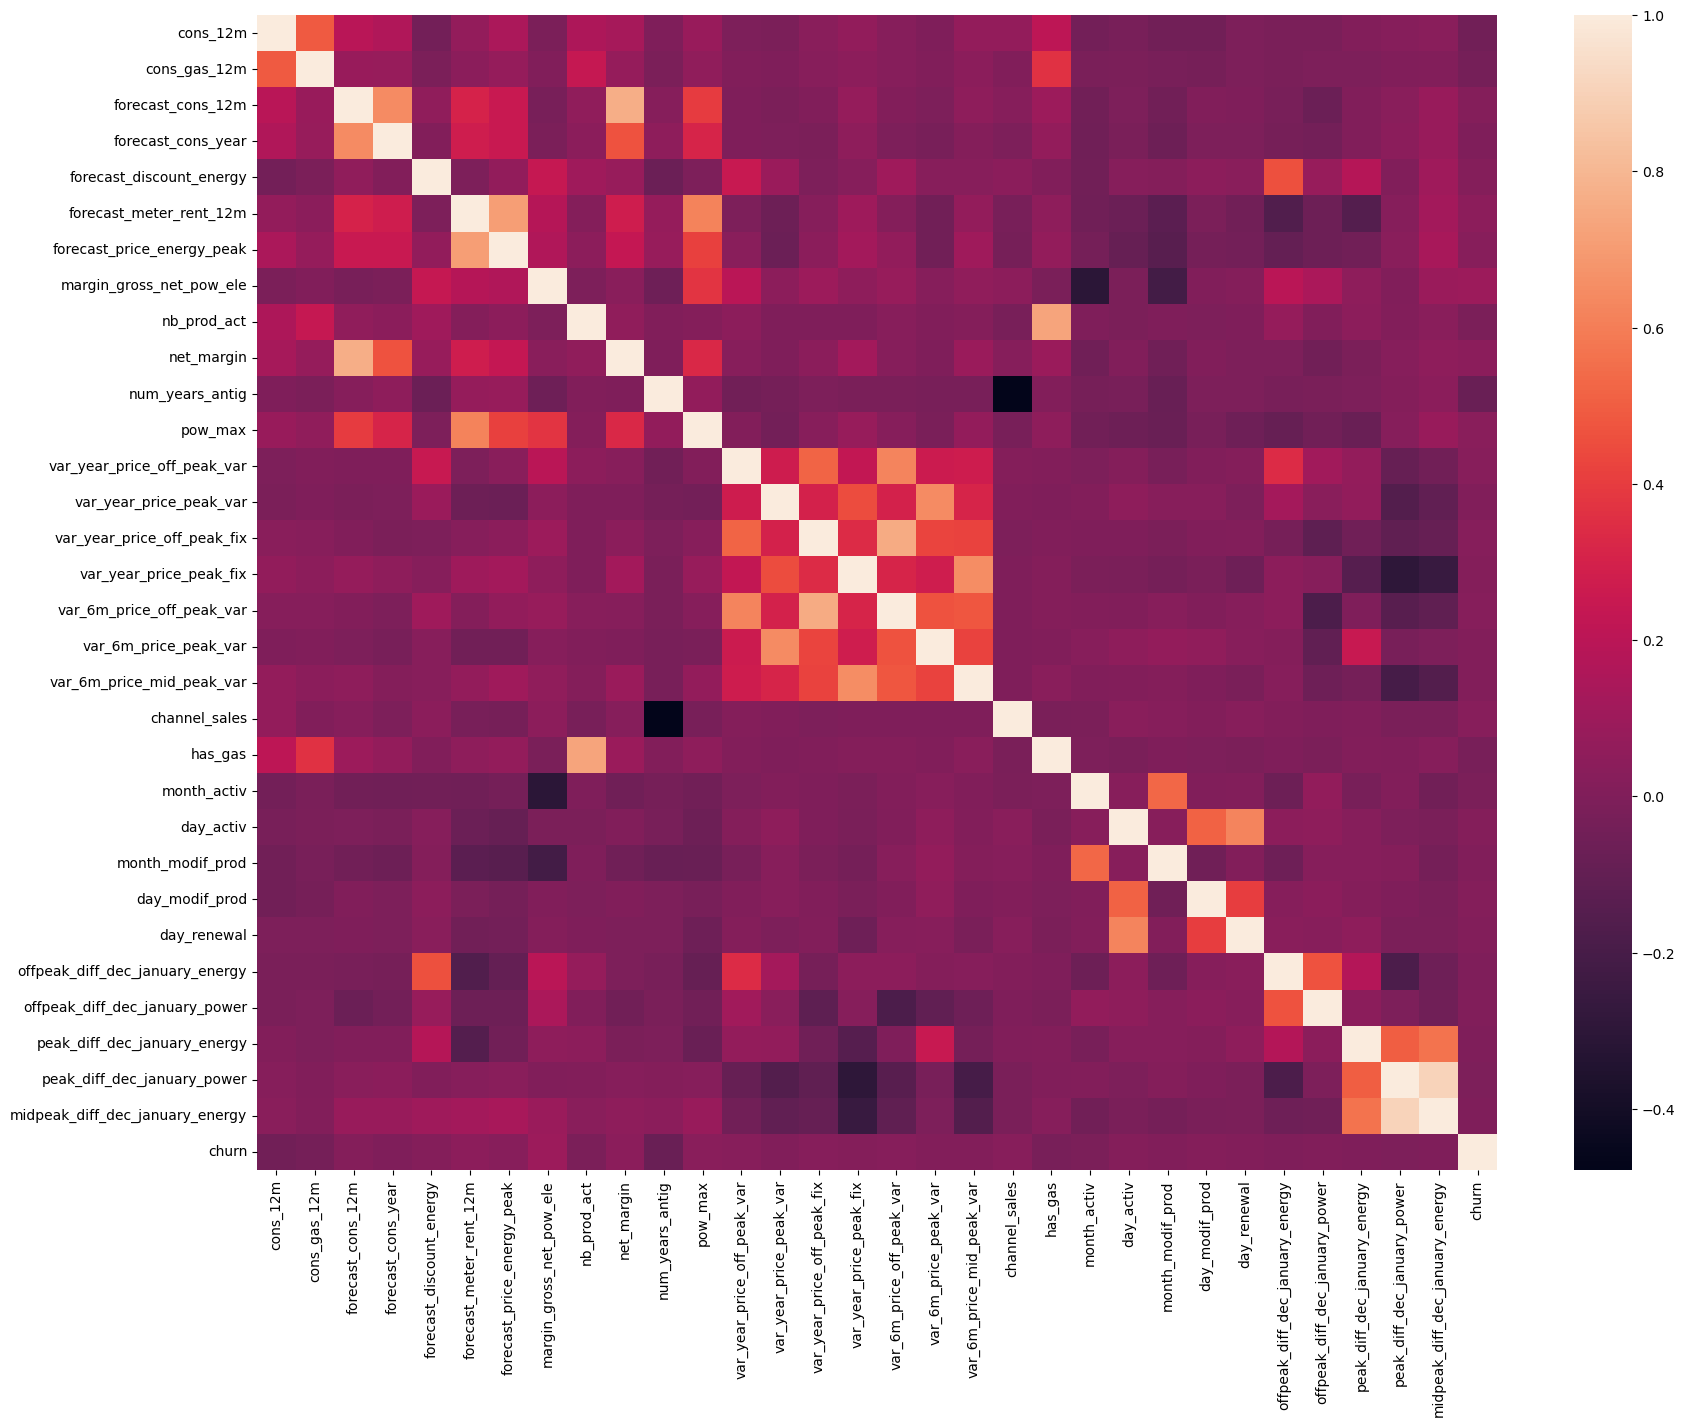

In [87]:
cor = clean_vif_df.corr()
plt.rcParams["figure.figsize"] = (20.0, 15.0)
sns.heatmap(cor)
plt.show()

This is the final result of the cleaning the data through VIF and filtering. I would annotate it but it is an eye sore to view.

### Embedded

Hear I wanted to see if there was any more features that could be removed through LassCV.

In [92]:
las = LassoCV()
las.fit(X, y)
print("Best alpha: %f" % las.alpha_)
print("Best score: %f" % las.score(X,y))
coef = pd.Series(las.coef_, index = X.columns)

Best alpha: 7.806910
Best score: 0.002789


In [94]:
print(str(sum(coef != 0)) + " variables chosen and " +  str(sum(coef == 0)) + " eliminated variables")

3 variables chosen and 28 eliminated variables


I found this result to be quite destructive. The dataset was completely gutted.

Text(0.5, 1.0, 'Feature importance through Lasso Model')

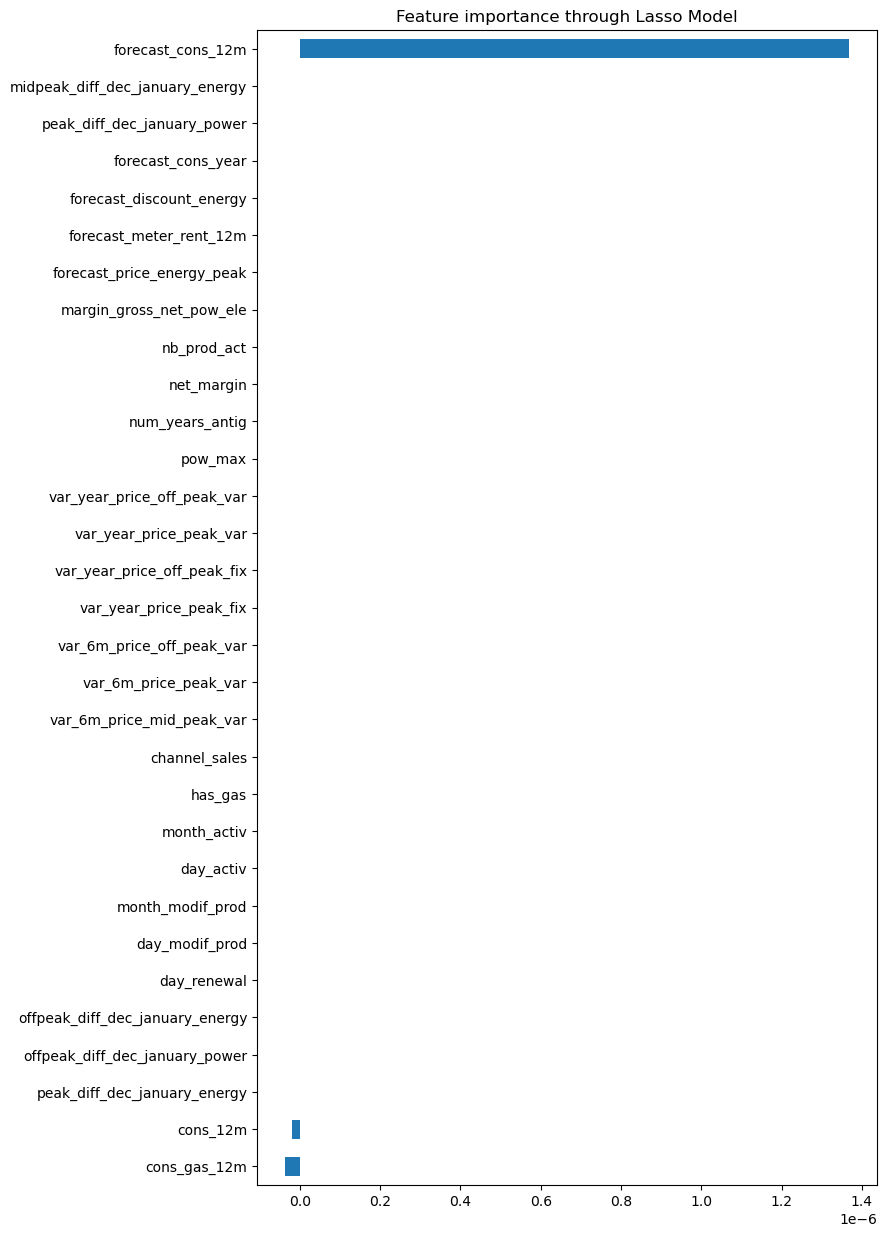

In [97]:
imp_coef = coef.sort_values()
plt.rcParams['figure.figsize'] = (8.0, 15.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance through Lasso Model")

I found this result interesting as when I was viewing the correlation and everythig with each technqiue, these 3 features never really stood out. So I will disregard this but have it here to show why I did not use it.

## Final

This is the end result of my dataset showing the amount of features I ended with and what they are.

In [102]:
print(f"Total of {len(clean_vif_df.columns)} columns including the churn")
print(clean_vif_df.columns)

Total of 32 columns including the churn
Index(['cons_12m', 'cons_gas_12m', 'forecast_cons_12m', 'forecast_cons_year',
       'forecast_discount_energy', 'forecast_meter_rent_12m',
       'forecast_price_energy_peak', 'margin_gross_net_pow_ele', 'nb_prod_act',
       'net_margin', 'num_years_antig', 'pow_max',
       'var_year_price_off_peak_var', 'var_year_price_peak_var',
       'var_year_price_off_peak_fix', 'var_year_price_peak_fix',
       'var_6m_price_off_peak_var', 'var_6m_price_peak_var',
       'var_6m_price_mid_peak_var', 'channel_sales', 'has_gas', 'month_activ',
       'day_activ', 'month_modif_prod', 'day_modif_prod', 'day_renewal',
       'offpeak_diff_dec_january_energy', 'offpeak_diff_dec_january_power',
       'peak_diff_dec_january_energy', 'peak_diff_dec_january_power',
       'midpeak_diff_dec_january_energy', 'churn'],
      dtype='object')


In [108]:
clean_vif_df.to_csv("Datasets/clean_vif_df.csv", index = False)